In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

##### 运行本文件同时预处理训练集和测试集，大约需要 20min 左右

### 读取数据

In [11]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.info()
df_test.info()

C:\Users\guoxu\AppData\Local\Temp\ipykernel_33772\3523920050.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')
C:\Users\guoxu\AppData\Local\Temp\ipykernel_33772\3523920050.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('test.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285285 entries, 0 to 285284
Columns: 627 entries, CUST_ID to L6_CHANNEL_TXN_DOUTTA_AVGCNT
dtypes: float64(399), int64(196), object(32)
memory usage: 1.3+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189766 entries, 0 to 189765
Columns: 626 entries, CUST_ID to L6_CHANNEL_TXN_DOUTTA_AVGCNT
dtypes: float64(393), int64(201), object(32)
memory usage: 906.3+ MB


In [12]:
df['bad_good'].value_counts()
# 测试集没有bad_good这一列
# 注意这里目标列两类分布极不均匀，57:1

bad_good
0    280401
1      4884
Name: count, dtype: int64

### 缺失值处理

In [13]:
null_num = 0
for col in list(df.columns):
    null_num += df[col].isnull().sum()
print(null_num)# 总缺失值数量

null_num = 0
for col in list(df_test.columns):
    null_num += df_test[col].isnull().sum()
print(null_num)# 测试集总缺失值数量

0
0


### Object类型数据处理

In [14]:
df_obj = df.select_dtypes('object').columns
print(len(df_obj))
print(df_obj)

32
Index(['IDF_TYP_CD', 'GENDER', 'CUST_EUP_ACCT_FLAG', 'CUST_AU_ACCT_FLAG',
       'CUST_SALARY_FINANCIAL_FLAG', 'CUST_SOCIAL_SECURITYIC_FLAG',
       'CUST_MTFLOW_FLAG', 'CUST_DOLLER_FLAG', 'CUST_INTERNATIONAL_GOLD_FLAG',
       'CUST_INTERNATIONAL_COMMON_FLAG', 'CUST_INTERNATIONAL_SIL_FLAG',
       'CUST_INTERNATIONAL_DIAMOND_FLAG', 'CUST_GOLD_COMMON_FLAG',
       'CUST_STAD_PLATINUM_FLAG', 'CUST_LUXURY_PLATINUM_FLAG',
       'CUST_PLATINUM_FINANCIAL_FLAG', 'CUST_DIAMOND_FLAG',
       'CUST_INFINIT_FLAG', 'CUST_BUSINESS_FLAG', 'DEP_SA_FLAG', 'DEP_TD_FLAG',
       'LOAN_FLAG', 'FUND_FLAG', 'C_FUND_FLAG', 'D_FUND_FLAG', 'S_FUND_FLAG',
       'BOND_FLAG', 'CER_BOND_FLAG', 'BK_BOND_FLAG', 'CRED_FLAG',
       'RELATED_REPAY_FLAG', 'TOT_REPAY_FLAG'],
      dtype='object')


In [15]:
df['IDF_TYP_CD'].value_counts()

IDF_TYP_CD
ZR01    280187
ZR03      1835
ZR22       708
ZR20       587
ZR21       552
ZR04       280
ZR11       248
ZR08       240
ZR09       232
ZR07       177
ZR05        78
ZR06        77
ZR02        50
ZR10        19
ZR13         7
ZR16         5
ZR12         2
ZR14         1
Name: count, dtype: int64

In [16]:
df['GENDER'].value_counts()

GENDER
1    108746
2    100150
1     38878
2     36398
X      1113
Name: count, dtype: int64

In [17]:
df['TOT_REPAY_FLAG'].value_counts()

TOT_REPAY_FLAG
N    244991
Y     40294
Name: count, dtype: int64

In [18]:
# 将IDF_TYP_CD提取为后两位数字
df['IDF_TYP_CD'] = df['IDF_TYP_CD'].apply(lambda row : int(row[2:]))
df_test['IDF_TYP_CD'] = df_test['IDF_TYP_CD'].apply(lambda row : int(row[2:]))

# 将gender中的字符'X'设置为3（待讨论）
df['GENDER'] = df['GENDER'].apply(lambda x: 3 if x == 'X' else int(x))
df_test['GENDER'] = df_test['GENDER'].apply(lambda x: 3 if x == 'X' else int(x))

# 将FLAG类属性列取值转换为0, 1
df_obj = df_obj.drop(['IDF_TYP_CD', 'GENDER'])
for col in df_obj:
    df[col] = df[col].apply(lambda x: 0 if x == 'N' else 1)
    df_test[col] = df_test[col].apply(lambda x: 0 if x == 'N' else 1)

### 冗余特征处理

In [19]:
# 统计取值个数为1或2的属性列(实际上也可以处理个数为3/4/5等的属性列)
col_value1 = []
col_value2 = []
for col in df.columns:
    diff_num = len(df[col].value_counts())
    if diff_num == 1:
        col_value1.append(col)
    elif diff_num == 2:
        col_value2.append(col)
print(len(col_value1))
print(len(col_value2))

91
37


In [20]:
# 原值非object类型的二值列
for col in col_value2:
    if col not in df_obj:
        print(col)
# 逐一查看取值情况，发现：
# bad_good  目标列
# guozhai_flag  285238: 47
# 其余8列取值分布均为 258284: 1(怀疑可能同时出现现在一个样本上，待进一步研究)

bad_good
guozhai_flag
CHANNEL_TELBANK_FINANCIAL_AMT
CHANNEL_TELBANK_FINANCIAL_CNT
L3_CHANNEL_TELBANK_FINANCIAL_MON
L3_CHANNEL_TELBANK_FINANCIAL_MO0
L6_CHANNEL_TELBANK_FINANCIAL_MON
L6_CHANNEL_TELBANK_FINANCIAL_MO0
L3_CHANNEL_DAY_MSPOS_CREDIT_MAXA
L6_CHANNEL_DAY_OTRPOS_CREDIT_MAX


In [21]:
# 删除无信息的索引列CUST_ID
df.drop('CUST_ID', inplace=True, axis=1)
df_test.drop('CUST_ID', inplace=True, axis=1)

# 删除取值全相同或几乎全相同的列(共99列)
to_drop = col_value1
for col in col_value2:
    if col not in df_obj and col not in ['bad_good', 'guozhai_flag']:
        to_drop.append(col)
df.drop(to_drop, inplace=True, axis=1)
df_test.drop(to_drop, inplace=True, axis=1)

In [22]:
# 删除相关系数大于0.999的属性列或与目标列bad_good相关系数小于0.001的属性列(共171列)
to_drop = set()
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if df.columns[i] != 'bad_good':
            if j > i and abs(df[df.columns[i]].corr(df[df.columns[j]])) > 0.999:
                to_drop.add(df.columns[j])
        else:
            if df.columns[j] != 'bad_good' and abs(df[df.columns[i]].corr(df[df.columns[j]])) < 0.001:
                to_drop.add(df.columns[j])
print(len(to_drop))
for col in to_drop:
    print(col)
df.drop(to_drop, inplace=True, axis=1)
df_test.drop(to_drop, inplace=True, axis=1)

171
L3_CHANNEL_TEL_SOUTTA_AVGAMT
L3_CHANNEL_INTER_OUT_MIN_AMT
L3DEP_SA_CREDIT_AMT
CER_BOND_FLAG
CUST_ASSET_AMT
L6_DEP_SA_NEW_AVG_BAL
L3_CUST_DIFF_OUT_AMT
L3_CHANNEL_CASH_OUT_MIN_AMT
L6_CHANNEL_MOBILE_IN_MIN_AMT
L3_CHANNEL_TRANS_OUT_MIN_AMT
CUST_INFINIT_FLAG
L3_CHANNEL_WEB_STAIN_MINAMT
CHANNEL_TEL_DOUTTA_AMT
L3_CHANNEL_DAY_OTRPOS_CREDIT_MAX
L3_CHANNEL_WEB_SOUTTA_MAXAMT
L6_CHANNEL_CASH_IN_MAX_AMT
L3_CHANNEL_AUTO_CASH_IN_MIN_AMT
L3_CHANNEL_OTHER_IN_MIN_AMT
L3_CHANNEL_TEL_SOUTTA_AVGCNT
L3_CHANNEL_AUTO_TRANS_IN_MIN_AMT
CHANNEL_WEB_DTAIN_AMT
L6_CHANNEL_WEB_DTAIN_MINAMT
CHANNEL_INTER_CREDIT_AMT
L3_DEP_SA_NEW_ACCOUNT_CNT
CHANNEL_CTR_FUND_AMT
L6_CHANNEL_DAY_OTRPOS_DEBIT_MAXA
L6_CHANNEL_CTR_FINANCIAL_MONTHAV
CHANNEL_WEB_DOUTTA_AMT
L6_CHANNEL_SIGLE_MSPOS_CREDIT_MI
CHANNEL_DAY_MSPOS_CREDIT_MAXAMT
L3_CHANNEL_CASH_IN_MAX_AMT
L3_CHANNEL_TELBANK_FUND_MONTHAVG
L6_CHANNEL_DAY_MSPOS_DEBIT_MINAM
L3_CHANNEL_MSPOS_CREDIT_AVG_CNT
L6_DEP_SA_NEW_ACCOUNT_CNT
DEP_SA_NEW_ACCOUNT_CNT
L3_CHANNEL_MOBILE_IN_MIN_AMT
L

### 异常值处理(待讨论)

Text(0.5, 1.0, 'Outlier rate of each column')

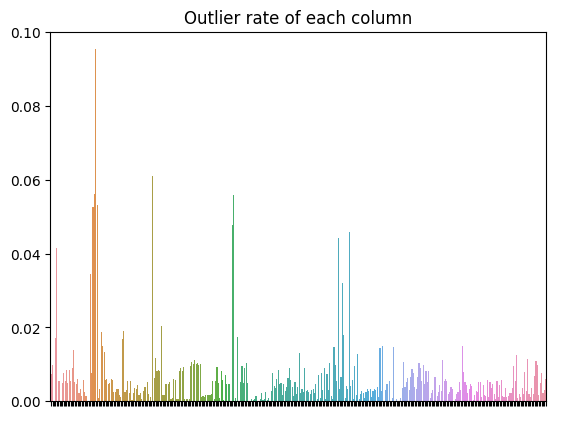

In [23]:
# 位于3 * sigma范围之外的数据占比应不超过0.003
outlier_rate = list()
for col in df.columns:
    mean = df[col].mean()
    std = df[col].std()
    upper_limit = mean + 3 * std
    lower_limit = mean - 3 * std
    condition = (df[col] > upper_limit)|(df[col] < lower_limit)
    outlier_rate.append(len(df.loc[condition])/len(df))

sns.barplot(x=np.arange(len(outlier_rate)), y=outlier_rate)
plt.xticks(color = 'white')
plt.title('Outlier rate of each column')

In [24]:
outlier_col = []
for i in range(len(outlier_rate)):
    if outlier_rate[i] > 0.003:
        outlier_col.append(df.columns[i])
print(len(outlier_col))
outlier_col

209


['OPEN_ORG_NUM',
 'IDF_TYP_CD',
 'bad_good',
 'LAST_OPEN_TENURE_DAYS',
 'G_OS_PRCP_SUM',
 'OS_PRCP_SUM_THREE',
 'L3_DR_AMT',
 'L3_DR_CNT',
 'DR_AMT',
 'DR_CNT',
 'L3_CR_AMT',
 'L3_CR_CNT',
 'CR_AMT',
 'CR_CNT',
 'CUST_ACCOUNT_CNT',
 'CUST_PRODUCT_CNT',
 'CUST_SAVING_AMT',
 'CUST_FINA_AMT',
 'CUST_FOND_AMT',
 'CUST_AUM',
 'CUST_INTERNATIONAL_GOLD_FLAG',
 'CUST_INTERNATIONAL_COMMON_FLAG',
 'CUST_INTERNATIONAL_SIL_FLAG',
 'CUST_INTERNATIONAL_DIAMOND_FLAG',
 'CUST_GOLD_COMMON_FLAG',
 'CUST_STAD_PLATINUM_FLAG',
 'CUST_DIAMOND_FLAG',
 'CUST_DEBT_AMT',
 'CUST_ACCOUNT_OPEN_CNT',
 'CUST_ACCOUNT_LOST_CNT',
 'L3_CUST_AVG_AUM',
 'L6_CUST_AVG_AUM',
 'L3_CUST_SAVING_AVGAMT',
 'L6_CUST_SAVING_AVGAMT',
 'L3_CUST_FINA_AVGAMT',
 'L6_CUST_FINA_AVGAMT',
 'L3_CUST_FOND_AVGAMT',
 'L6_CUST_FOND_AVGAMT',
 'L3_CUST_DEBT_AVG_AMT',
 'L6_CUST_DEBT_AVG_AMT',
 'CUST_DIFF_IN_AMT',
 'CUST_SAME_IN_CNT',
 'CUST_SAME_OUT_CNT',
 'L3_CUST_DIFF_IN_AMT',
 'L3_CUST_SAME_OUT_AMT',
 'L3_CUST_SAME_IN_CNT',
 'L6_CUST_DIFF_IN_AMT

### 连续值归一化&离散值调整(待讨论)

In [25]:
# # 归一化
# for i in df.columns:
#     df[i] = df[i].astype(float)
#     df[i] = (df[i]-df[i].min())/(df[i].max()-df[i].min())

In [26]:
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285285 entries, 0 to 285284
Columns: 356 entries, OPEN_ORG_NUM to L6_CHANNEL_AUTO_DOUTTA_AVGCNT
dtypes: float64(260), int64(96)
memory usage: 774.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189766 entries, 0 to 189765
Columns: 355 entries, OPEN_ORG_NUM to L6_CHANNEL_AUTO_DOUTTA_AVGCNT
dtypes: float64(259), int64(96)
memory usage: 514.0 MB


In [27]:
# 将DataFrame写入CSV文件
df.to_csv('processed.csv', mode='w', index=False)
df_test.to_csv('processed_test.csv', mode='w', index=False)